In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import datacleaning
import itertools
from nltk.probability import FreqDist
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [112]:
def do_centrality(G: nx.Graph):
    deg = pd.DataFrame(nx.degree_centrality(G).items(), columns=['Id', 'degree_centrality'])
    # eig = pd.DataFrame(nx.eigenvector_centrality_numpy(G, weight="Weight").items(), columns=['Id', 'eigenvector_centrality'])
    merged = pd.merge(data[['Id','title']], deg, on = "Id")
    return merged

data = pd.read_csv("data_small.csv", converters={"ingredient_words": literal_eval,"instruction_words": literal_eval})
data = data.rename(columns={"Unnamed: 0":"Id"})

In [3]:
graph_instruction = nx.read_gexf("recipe_instruction_small.gexf")
graph_ingredient = nx.read_gexf("recipe_ingredient_small.gexf")

graph_recipe_instruction_allwords = nx.read_gexf("recipe_instruction_nofilter.gexf")
graph_recipe_ingredient_allwords = nx.read_gexf("recipe_ingredient_nofilter.gexf")

graph_recipe_instruction_tfidf = nx.read_gexf("recipe_instruction_tfidf.gexf")
graph_recipe_ingredient_tfidf = nx.read_gexf("recipe_ingredient_tfidf.gexf")

graph_recipe_instruction_ranked_tfidf = nx.read_gexf("recipe_instruction_ranked_tfidf.gexf")
graph_recipe_ingredient_ranked_tfidf = nx.read_gexf("recipe_ingredient_ranked_tfidf.gexf")

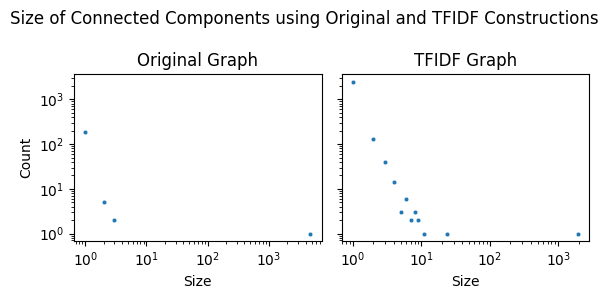

In [4]:
def count_components(G: nx.graph):
    graph_CCs = sorted(nx.connected_components(G), key=len, reverse=True)

    graph_CCs_subgraphs = [G.subgraph(c).copy() for c in graph_CCs]

    lens = [len(g) for g in graph_CCs_subgraphs]
    s, count = np.unique(np.sort(lens), return_counts=True)
    return np.asarray((s,count))

def plot_components(data, axes):
    a = sns.scatterplot(x = data[0], y = data[1], ax=axes, s=10)
    a.set_xscale('log')
    a.set_yscale('log')

fig, axes = plt.subplots(1,2, figsize= (6,3), sharey=True)
plot_components(count_components(graph_ingredient), axes=axes[0])
plot_components(count_components(graph_recipe_ingredient_tfidf), axes=axes[1])
axes[0].set_title("Original Graph")
axes[1].set_title("TFIDF Graph")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Size")
axes[1].set_xlabel("Size")
fig.suptitle("Size of Connected Components using Original and TFIDF Constructions")

fig.tight_layout()
plt.savefig('figs/original_tfidf_components.pdf')

In [5]:
# (do_centrality(graph_ingredient)).sort_values(by = 'degree_centrality', ascending = False)

In [6]:
# (do_centrality(graph_instruction)).sort_values(by = 'degree_centrality', ascending = False)

In [7]:
# (do_centrality(graph_recipe_ingredient_tfidf)).sort_values(by = 'degree_centrality', ascending = False)


In [52]:
graphs = [graph_ingredient, graph_instruction, graph_recipe_ingredient_allwords, graph_recipe_instruction_allwords, graph_recipe_ingredient_tfidf, graph_recipe_instruction_tfidf, graph_recipe_ingredient_ranked_tfidf, graph_recipe_instruction_ranked_tfidf]

In [9]:
graph_pairs = itertools.combinations(graphs, r=2)

In [57]:
import scipy
names = ["Original Ingredient", "Original Instruction", "All Ingredient Words", "All Instruction Words", "TFIDF Ingredient", "TFIDF Instruction", "Ranked TFIDF Ingredient", "Ranked TFIDF Instruction"]
graph_distance = pd.DataFrame(np.zeros(shape = (len(graphs), len(graphs))), columns=names)
graph_distance.insert(0, 'i', names)
graph_distance = graph_distance.set_index('i')
for i in range(len(graphs)):
    for j in range(len(graphs)):
        if i>j:
            Mi = nx.adjacency_matrix(graphs[i])
            Mj = nx.adjacency_matrix(graphs[j])

            Mi = Mi/scipy.sparse.linalg.norm(Mi)
            Mj = Mj/scipy.sparse.linalg.norm(Mj)
            graph_distance.iloc[i,j] = scipy.sparse.linalg.norm(Mi - Mj)

#     for j in range(len(graphs)):
#         if i<j:
#             graph_distance[i,j] = 1
            # graph_distance[i,j] = 

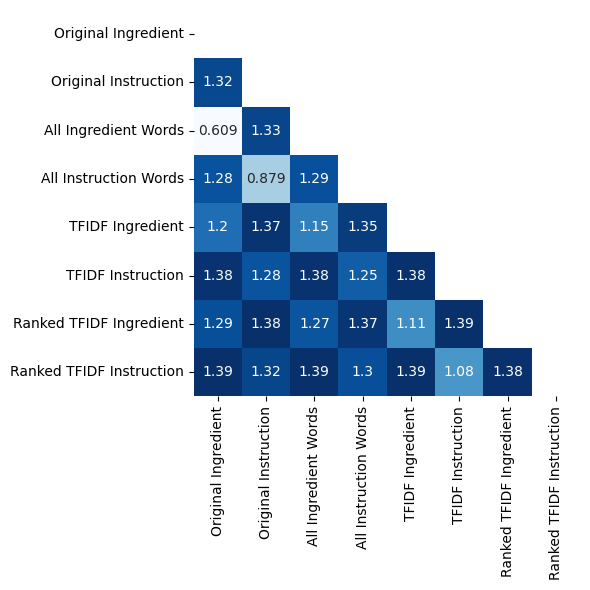

In [141]:
fig, ax = plt.subplots(1,1, figsize= (6,6), sharey=True)
a=sns.heatmap(graph_distance, annot=True, cmap="Blues", ax=ax, cbar = False, fmt='.3g', mask=(graph_distance==0))
a.set_ylabel("")
# fig.suptitle("Distance Between Alternate Constructions")
fig.tight_layout()
plt.savefig('figs/all_graphdistance.pdf')



In [12]:
def do_centralities(G: nx.Graph):
    deg = pd.DataFrame(nx.degree_centrality(G).items(), columns=['Id', 'degree_centrality'])
    pagerank = pd.DataFrame(nx.pagerank(G, weight="Weight").items(), columns=['Id', 'pagerank_centrality'])
    betweenness = pd.DataFrame(nx.betweenness_centrality(G, weight="Weight").items(), columns=['Id', 'betweenness_centrality'])
    merged = pd.merge(data, deg, on = "Id")
    merged = pd.merge(merged, pagerank, on = "Id")
    merged = pd.merge(merged, betweenness, on = "Id")
    return merged

In [13]:
data

,Id,title,ingredients,instructions,picture_link,clean_ingredients,clean_instructions,clean_instructions_masked,title_words,ingredient_words,instruction_words,index
0,5eA5nRW8VgbOry0hsA.SVnrGkt2AdzO,Southern-Style Chocolate Pound Cake,1 cup butter ADVERTISEMENT 1/2 cup shortening ...,Preheat oven to 350 degrees F (175 degrees C)....,v.IiJhm4GZSZAGtMDWpTfAe6vspLCiu,butter shortening white sugar eggs vanilla ext...,preheat oven degrees degrees grease flour loaf...,preheat oven degrees degrees grease loaf pans ...,"['southernstyle', 'chocolate', 'pound', 'cake']","[butter, shortening, white, sugar, eggs, vanil...","[preheat, oven, degrees, degrees, grease, loaf...",5eA5nRW8VgbOry0hsA.SVnrGkt2AdzO
1,DIzfv.NycIqtwo58y7fteog1dKRw12O,Pumpkin Pie I,1 egg ADVERTISEMENT 1 tablespoon all-purpose f...,Preheat oven to 450 degrees F (230 degrees C)....,EbVR3lftwDSDeE1MRSGdi1evygKF/D6,egg allpurpose flour white sugar salt pumpkin ...,preheat oven degrees degrees add sugar gradual...,preheat oven degrees degrees add gradually bea...,"['pumpkin', 'pie', 'i']","[egg, allpurpose, flour, white, sugar, salt, p...","[preheat, oven, degrees, degrees, add, gradual...",DIzfv.NycIqtwo58y7fteog1dKRw12O
2,TFxp0RPK/1PxAnjYiZUS0KztkgYb3iW,Cinnamon Oatmeal Zucchini Cookies,"1 1/2 cups butter, softened ADVERTISEMENT 1 1/...",Preheat oven to 350 degrees F (175 degrees C)....,jG7CnWbsc8cYsoHbreIorq8Uvyzzk/6,butter softened white sugar eggs vanilla extra...,preheat oven degrees degrees grease baking she...,preheat oven degrees degrees grease sheets bea...,"['cinnamon', 'oatmeal', 'zucchini', 'cookies']","[butter, softened, white, sugar, eggs, vanilla...","[preheat, oven, degrees, degrees, grease, shee...",TFxp0RPK/1PxAnjYiZUS0KztkgYb3iW
3,3yH5Jc6HLmEnJw5ggLqI11oeBiSpwBy,Plum-Oat Drop Biscuits,2 tablespoons white sugar ADVERTISEMENT 1/2 te...,Preheat oven to 450 degrees F (230 degrees C)....,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,white sugar ground cinnamon allpurpose flour r...,preheat oven degrees degrees grease baking she...,preheat oven degrees degrees grease sheet comb...,"['plumoat', 'drop', 'biscuits']","[white, sugar, ground, cinnamon, allpurpose, f...","[preheat, oven, degrees, degrees, grease, shee...",3yH5Jc6HLmEnJw5ggLqI11oeBiSpwBy
4,8lZak.EVdLP9/dukyN72DYHyjseFwV2,Ghirardelli Milk Chocolate Chip Cookies,2 1/4 cups all-purpose flour ADVERTISEMENT 1 t...,Preheat the oven to 375 degrees F. Stir togeth...,50UyVqBQayirbQ47M.8oJvkETheUGFW,allpurpose flour baking soda salt unsalted but...,preheat oven degrees stir together flour bakin...,preheat oven degrees stir together set aside b...,"['ghirardelli', 'milk', 'chocolate', 'chip', '...","[allpurpose, flour, baking, soda, salt, unsalt...","[preheat, oven, degrees, stir, together, set, ...",8lZak.EVdLP9/dukyN72DYHyjseFwV2
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,z5ZKH66nGOR2cgkzDl5vGj4DPX/J95O,Sun-Dried Tomato With Fresh Basil Spread,1/2 cup oil-packed sun-dried tomatoes ADVERTIS...,Place sun-dried tomatoes in the work bowl of a...,IV7I3CRDxEMTrdHzOCE3YHxewYs0JQW,oilpacked sundried tomatoes basil leaves ounce...,place sundried tomatoes work bowl food process...,place work bowl food processor pulse coarsely ...,"['sundried', 'tomato', 'with', 'fresh', 'basil...","[oilpacked, sundried, tomatoes, basil, leaves,...","[place, work, bowl, food, processor, pulse, co...",z5ZKH66nGOR2cgkzDl5vGj4DPX/J95O
4996,g1mQzPtIoBSaOaaHSkMj7cObWt0r5.K,Banana Split Martini,ice as needed ADVERTISEMENT 2 fluid ounces whi...,Fill a cocktail shaker with ice; add white cho...,qE58a7Z1Au0GXvPO188iHZZVqna9hLa,ice needed fluid ounces white chocolate liqueu...,fill cocktail shaker ice add white chocolate l...,fill cocktail shaker add creme de cover shake ...,"['banana', 'split', 'martini']","[ice, needed, fluid, ounces, white, chocolate,...","[fill, cocktail, shaker, add, creme, de, cover...",g1mQzPtIoBSaOaaHSkMj7cObWt0r5.K
4997,dsDOddsQtDp7xomWY2mQwcoTyLeUfYa,Citrus Glazed Banana Squash,"1 1/2 pounds banana squash, peeled and cu

In [14]:
# instruction_ranked_tfidf_cent = do_centralities(graph_recipe_instruction_ranked_tfidf)

In [15]:
instructions_idf = pd.read_csv("instructions_idf.csv")
ingredients_idf = pd.read_csv("ingredients_idf.csv")

instructions_idf = instructions_idf.drop(columns= 'Unnamed: 0')
ingredients_idf = ingredients_idf.drop(columns= 'Unnamed: 0')

def calculate_idf_sum(instructions, idfs):
    instruction_words = instructions.split()
    wordset = set(idfs['word'])
    idfs = idfs.set_index('word')
    sum = 0
    for word in instruction_words:
        if word in wordset: 
            sum = sum + idfs.loc[word]
    return(sum) 

calculate_idf_sum("preheat oven degrees", instructions_idf)

def all_idf_sum(dat, idfs):
    dat['sum_idf'] = dat.apply(lambda l: calculate_idf_sum(l['clean_instructions_masked'], idfs=idfs), axis=1)
    return dat

In [16]:
# instructions_idf = pd.concat([ingredients_idf,instructions_idf])

# instruction_ranked_tfidf_cent['sum_idf'] = instruction_ranked_tfidf_cent['clean_instructions_masked']



NameError: name 'instruction_ranked_tfidf_cent' is not defined

In [17]:
# fig, axes = plt.subplots(1,1, figsize= (6,6))
# sns.scatterplot(x=instruction_ranked_tfidf_cent['betweenness_centrality'], y=instruction_ranked_tfidf_cent['sum_idf'], size = .1, alpha = .1)
# fig.tight_layout()
# instruction_ranked_tfidf_cent.to_csv('instruction_ranked_tfidf_cent.csv')
# instruction_ranked_tfidf_cent = all_idf_sum(instruction_ranked_tfidf_cent, instructions_idf)

NameError: name 'instruction_ranked_tfidf_cent' is not defined

In [18]:
instruction_ranked_tfidf_cent = pd.read_csv('instruction_ranked_tfidf_cent.csv', converters={"ingredient_words": literal_eval,"instruction_words": literal_eval})

In [19]:

instruction_ranked_tfidf_cent.sort_values(by='betweenness_centrality', ascending=False).head(10)

,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,...,clean_ingredients,clean_instructions,clean_instructions_masked,ingredient_words,instruction_words,index,degree_centrality,pagerank_centrality,betweenness_centrality,sum_idf
3474,3474,3474,3474,3474,3474,3474,3474,3474,3474,Ug6Rt5Zkk7kqV6XT15TPCxHICZFT3/W,...,vegetable oil finely chopped onion minced garl...,heat vegetable oil saucepan mediumhigh heat co...,heat saucepan mediumhigh heat cook stir tender...,"[vegetable, oil, finely, chopped, onion, mince...","[heat, saucepan, mediumhigh, heat, cook, stir,...",Ug6Rt5Zkk7kqV6XT15TPCxHICZFT3/W,0.009602,0.002275,0.070661,39.296091
586,586,586,586,586,586,586,586,586,586,gjbjEVVvs/bCyogg5YNHeoRt9ZY1.j2,...,olive oil onion diced cloves garlic crushed gr...,heat olive oil large skillet medium heat cook ...,heat large skillet medium heat cook stir tende...,"[olive, oil, onion, diced, cloves, garlic, cru...","[heat, large, skillet, medium, heat, cook, sti...",gjbjEVVvs/bCyogg5YNHeoRt9ZY1.j2,0.006001,0.001437,0.047740,86.394946
4850,4850,4850,4850,4850,4850,4850,4850,4850,4850,AjyqfITWPPoborWgRWTpqpn8hskX6V2,...,macaroni cooked chili beans sweet corn drained...,preheat oven degrees degrees large bowl combin...,preheat oven degrees degrees large bowl combin...,"[macaroni, cooked, chili, beans, sweet, corn, ...","[preheat, oven, degrees, degrees, large, bowl,...",AjyqfITWPPoborWgRWTpqpn8hskX6V2,0.004001,0.000990,0.043518,37.528161
2933,2933,2933,2933,2933,2933,2933,2933,2933,2933,n/Tkhv693Sl69p7Gpzkd2d1DaW0c1pi,...,water divided dried mung beans millet vegetabl...,bring water mung beans boil pot cover reduce h...,bring boil pot cover reduce heat mediumlow sim...,"[water, divided, dried, mung, beans, millet, v...","[bring, boil, pot, cover, reduce, heat, medium...",n/Tkhv693Sl69p7Gpzkd2d1DaW0c1pi,0.003401,0.000797,0.037250,97.307047
4567,4567,4567,4567,4567,4567,4567,4567,4567,4567,osOWZ7F29BABvQJvKGFne7h7B0GcLM2,...,allpurpose flour yellow cornmeal white sugar b...,preheat oven degrees degrees lightly grease x ...,preheat oven degrees degrees grease x pan larg...,"[allpurpose, flour, yellow, cornmeal, white, s...","[preheat, oven, degrees, degrees, grease, x, p...",osOWZ7F29BABvQJvKGFne7h7B0GcLM2,0.003601,0.000919,0.035274,81.261066
274,274,274,274,274,274,274,274,274,274,2CezPqmLlRtrlvMt6XzzXqSk3sd1.I.,...,sour cream condensed cream chicken soup white ...,preheat oven degrees degrees combine sour crea...,preheat oven degrees degrees combine mix well ...,"[sour, cream, condensed, cream, chicken, soup,...","[preheat, oven, degrees, degrees, combine, mix...",2CezPqmLlRtrlvMt6XzzXqSk3sd1.I.,0.004001,0.000985,0.035155,34.762203
3701,3701,3701,3701,3701,3701,3701,3701,3701,3701,OHGzldiGToERtjNpncwROa5AroDcMvS,...,vegetable oil basmati rice coconut milk cans c...,heat oil large pot mediumhigh heat stir rice c...,heat large pot mediumhigh heat stir cook minut...,"[vegetable, oil, basmati, rice, coconut, milk,...","[heat, large, pot, mediumhigh, heat, stir, coo...",OHGzldiGToERtjNpncwROa5AroDcMvS,0.004801,0.001124,0.034420,38.574166
1681,1681,1681,1681,1681,1681,1681,1681,1681,1681,4XcOu9d85WM.So51E6mx8H2g4hN9egu,...,chopped cooked chicken meat cooked white rice ...,preheat oven degrees degrees large bowl combin...,preheat oven degrees degrees large bowl combin...,"[chopped, cooked, chicken, meat, cooked, white...","[preheat, oven, degrees, degrees, large, bowl,...",4XcOu9d85WM.So51E6mx8H2g4hN9egu,0.002601,0.000643,0.031751,50.213064
1488,1488,1488,1488,1488,1488,1488,1488,1488,1488,T1xROF1DYf4GjWkpXosiw6qS6uvV51O,...,hot water mayonnaise vanilla extract white sug...,preheat oven degrees degrees grease flour x pa...,preheat oven degrees degrees grease x pan sift...,"[hot, water, mayonnaise, vanilla, extract, whi...","[preheat, oven, degrees, degrees, grease, x, p...",T1xROF1DYf4GjWkpXosiw6qS6uvV51O,0.001800,0.000462,0.031255,44.382533
4016,4016,4016,4016,4016,4016,4016,4016,401

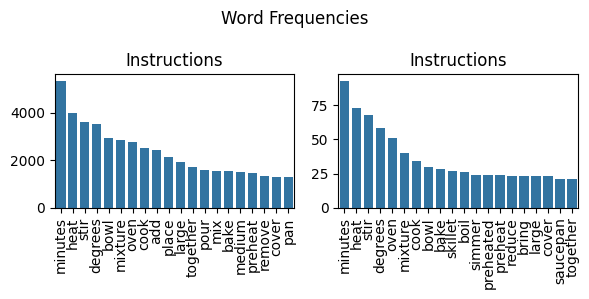

In [20]:
import statistics
stddv = statistics.stdev(instruction_ranked_tfidf_cent['betweenness_centrality'])
mean = statistics.mean(instruction_ranked_tfidf_cent['betweenness_centrality'])
# sns.histplot(data=instruction_ranked_tfidf_cent, x='betweenness_centrality')

A = instruction_ranked_tfidf_cent[instruction_ranked_tfidf_cent['betweenness_centrality'] < mean]
A = FreqDist(list(itertools.chain.from_iterable(A["instruction_words"])))
B = instruction_ranked_tfidf_cent[instruction_ranked_tfidf_cent['betweenness_centrality'] > mean + 4*stddv]
B = FreqDist(list(itertools.chain.from_iterable(B["instruction_words"])))

inst1 = ((pd.DataFrame({a:[b] for a, b in [item for item in A.items()]})).T.reset_index())
inst2 = ((pd.DataFrame({a:[b] for a, b in [item for item in B.items()]})).T.reset_index())

inst1 = inst1.sort_values(by=0, ascending=False).head(20)
inst2 = inst2.sort_values(by=0, ascending=False).head(20)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

a = sns.barplot(y=inst1[0], x=inst1['index'], ax = axes[0])
a.tick_params(axis='x', rotation=90)
a.set_xlabel("")
a.set_ylabel("")
a.set_title("Instructions")

b = sns.barplot(y=inst2[0], x=inst2['index'], ax = axes[1])
b.tick_params(axis='x', rotation=90)
b.set_xlabel("")
b.set_ylabel("")
b.set_title("Instructions")

fig.suptitle("Word Frequencies")
fig.tight_layout()

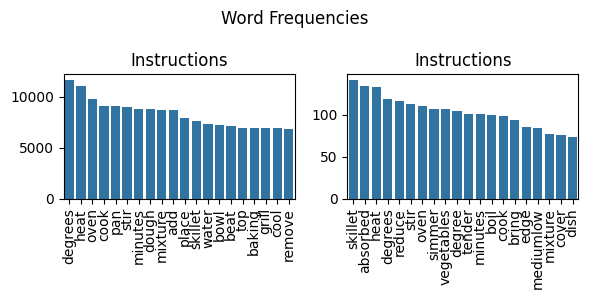

In [21]:
import statistics
stddv = statistics.stdev(instruction_ranked_tfidf_cent['betweenness_centrality'])
mean = statistics.mean(instruction_ranked_tfidf_cent['betweenness_centrality'])
# sns.histplot(data=instruction_ranked_tfidf_cent, x='betweenness_centrality')

A = instruction_ranked_tfidf_cent[instruction_ranked_tfidf_cent['betweenness_centrality'] < mean]
A = FreqDist(list(itertools.chain.from_iterable(A["instruction_words"])))
B = instruction_ranked_tfidf_cent[instruction_ranked_tfidf_cent['betweenness_centrality'] > mean + 5*stddv]
B = FreqDist(list(itertools.chain.from_iterable(B["instruction_words"])))

inst1 = ((pd.DataFrame({a:[b] for a, b in [item for item in A.items()]})).T.reset_index()).rename(columns={'index':"word",0:'count'})
inst2 = ((pd.DataFrame({a:[b] for a, b in [item for item in B.items()]})).T.reset_index()).rename(columns={'index':"word",0:'count'})

inst1 = inst1.merge(instructions_idf, on = 'word')
inst1['weighted_frequency'] = inst1['count'] * (inst1['weight']**2)
inst2 = inst2.merge(instructions_idf, on = 'word')
inst2['weighted_frequency'] = inst2['count'] * (inst2['weight']**2)

inst1 = inst1.sort_values(by='weighted_frequency', ascending=False).head(20)
inst2 = inst2.sort_values(by='weighted_frequency', ascending=False).head(20)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

a = sns.barplot(y=inst1['weighted_frequency'], x=inst1['word'], ax = axes[0])
a.tick_params(axis='x', rotation=90)
a.set_xlabel("")
a.set_ylabel("")
a.set_title("Instructions")

b = sns.barplot(y=inst2['weighted_frequency'], x=inst2['word'], ax = axes[1])
b.tick_params(axis='x', rotation=90)
b.set_xlabel("")
b.set_ylabel("")
b.set_title("Instructions")

fig.suptitle("Word Frequencies")
fig.tight_layout()

In [22]:
inst_communities = nx.community.louvain_communities(graph_recipe_instruction_ranked_tfidf, resolution=2,seed=2024)
ingr_communities = nx.community.louvain_communities(graph_recipe_ingredient_ranked_tfidf, resolution=2,seed=2024)
# for level in inst_communities:
#     print(sorted([len(com) for com in level])[::-1])

In [23]:
inst_communities = sorted(inst_communities, key=len)[::-1]
ingr_communities = sorted(ingr_communities, key=len)[::-1]

In [24]:
([len(community) for community in inst_communities])

[197,
 186,
 146,
 135,
 127,
 127,
 125,
 120,
 119,
 115,
 114,
 112,
 110,
 108,
 105,
 98,
 97,
 95,
 93,
 93,
 90,
 90,
 87,
 86,
 79,
 76,
 74,
 74,
 73,
 72,
 69,
 68,
 68,
 67,
 66,
 64,
 62,
 61,
 59,
 58,
 56,
 56,
 55,
 53,
 53,
 51,
 50,
 49,
 48,
 47,
 46,
 43,
 42,
 42,
 40,
 38,
 37,
 37,
 37,
 35,
 33,
 31,
 24,
 23,
 23,
 21,
 15,
 14,
 12,
 7,
 6,
 5,
 3,
 3]

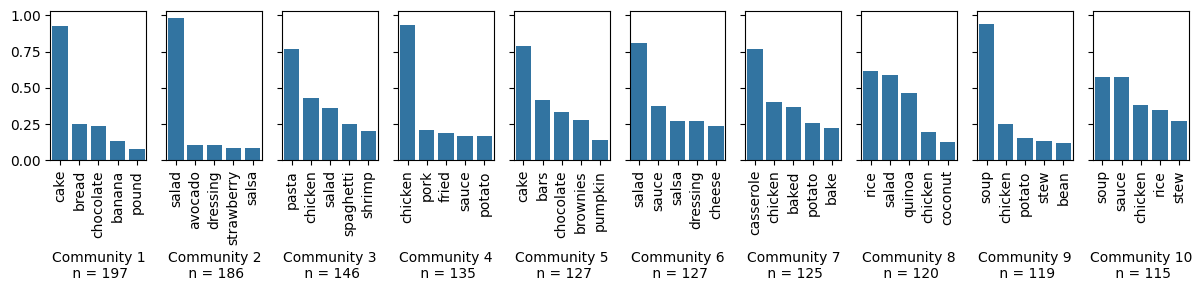

In [25]:
# datacleaning.data_for_nodes(inst_communities[0])
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
n=10
k=5
def title_dist_for_nodes(nodes, axes):
    dats = datacleaning.data_for_nodes(nodes)
    dats['title_words'] = dats['title'].replace(r'[^a-zA-Z\s]', '', regex=True)
    dats['title_words'] = dats['title_words'].str.lower()
    dats['title_words'] = dats['title_words'].str.split()
    
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if len(word) > 3])
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if word not in stop_words])
    title_words = list(itertools.chain.from_iterable(dats["title_words"]))
    title_freqs = pd.DataFrame(sorted(FreqDist(title_words).most_common(k), key=lambda x: x[1], reverse=True))
    sns.barplot(x=title_freqs[0], y=title_freqs[1]/np.linalg.norm(title_freqs[1]), ax= axes)
    return title_words


fig, ax = plt.subplots(1,n, figsize= (12,3), sharey=True)
i = 1
plt_i = 0
for community in inst_communities:
    if len(community) < 100:
        i = i + 1
        continue
    if plt_i >= n:
        break

    title_dist_for_nodes(inst_communities[i], ax[plt_i])
    ax[plt_i].tick_params('x', labelrotation=90)
    ax[plt_i].set_xlabel("Community " + str(i) + "\n n = " + str(len(community)))
    ax[plt_i].set_ylabel("")

    plt_i = plt_i + 1
    i = i + 1

fig.align_xlabels()
fig.tight_layout()



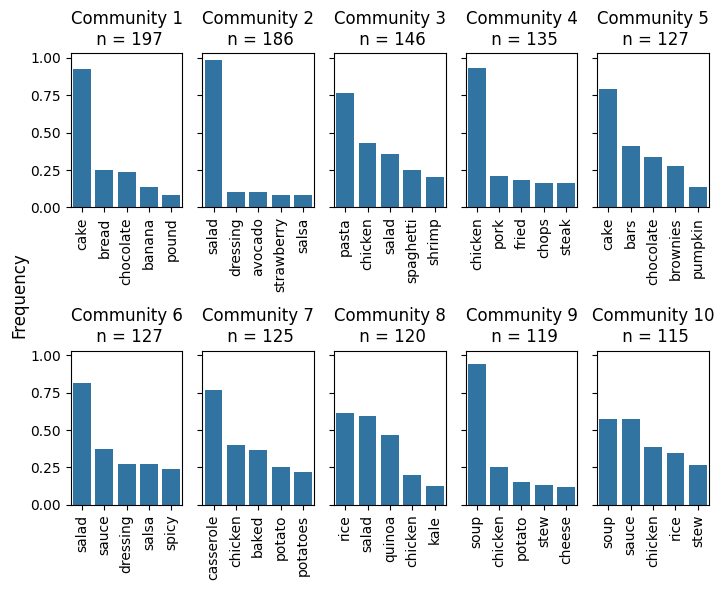

In [143]:
n=10
k=5
def title_dist_for_nodes(nodes, axes):
    dats = datacleaning.data_for_nodes(nodes)
    dats['title_words'] = dats['title'].replace(r'[^a-zA-Z\s]', '', regex=True)
    dats['title_words'] = dats['title_words'].str.lower()
    dats['title_words'] = dats['title_words'].str.split()
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if len(word) > 3])
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if word not in stop_words])
    
    title_words = list(itertools.chain.from_iterable(dats["title_words"]))
    title_freqs = pd.DataFrame(list(FreqDist(title_words).items()), columns = ["word","frequency"])

    title_freqs['weighted_frequency'] = title_freqs['frequency']
    title_freqs = title_freqs.sort_values(by = 'weighted_frequency', ascending= False).head(5)

    sns.barplot(x=title_freqs['word'], y=title_freqs['weighted_frequency']/np.linalg.norm(title_freqs['weighted_frequency']), ax= axes, errorbar=('ci', 0))
    return title_words

def plot_communities(communities):
    fig, ax = plt.subplots(2,int(n/2), figsize= (7,6), sharey=True)
    i = 1
    plt_i = 0
    plt_j = 0
    for community in communities:
        if len(community) < 100:
            i = i + 1
            continue
        if plt_i + int(n/2)*plt_j >= n:
            break
        if plt_i == int(n/2):
            plt_j = 1
            plt_i = 0
        title_dist_for_nodes(communities[i], ax[plt_j, plt_i])
        ax[plt_j, plt_i].tick_params('x', labelrotation=90)
        ax[plt_j, plt_i].set_title("Community " + str(i) + "\n n = " + str(len(community)))
        ax[plt_j, plt_i].set_ylabel("")
        ax[plt_j, plt_i].set_xlabel("")

        plt_i = plt_i + 1
        i = i + 1
    fig.text(-.02, 0.5, 'Frequency', va='center', rotation='vertical', size='large')
    # fig.suptitle("Title Word Frequency by Instruction Community")
    fig.align_xlabels()
    fig.tight_layout()


plot_communities(inst_communities)

plt.savefig('figs/tfidf_instcommunity_titles.pdf')

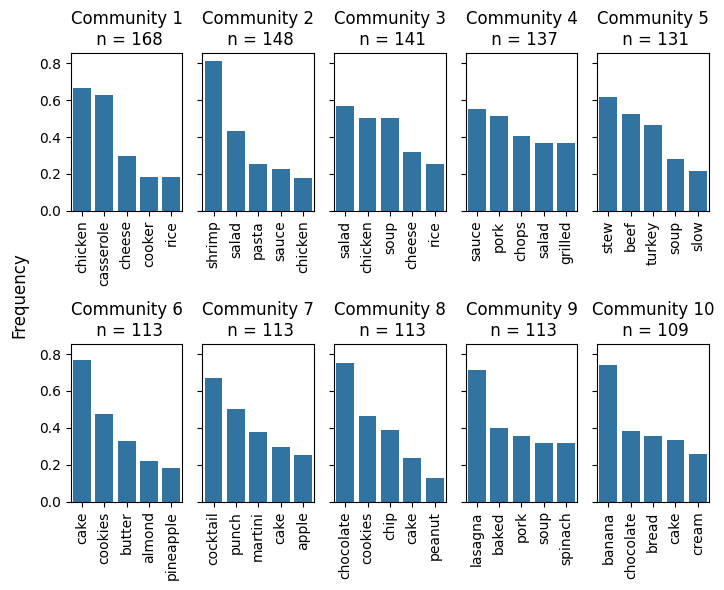

In [142]:
n=10
k=5
def title_dist_for_nodes(nodes, axes):
    dats = datacleaning.data_for_nodes(nodes)
    dats['title_words'] = dats['title'].replace(r'[^a-zA-Z\s]', '', regex=True)
    dats['title_words'] = dats['title_words'].str.lower()
    dats['title_words'] = dats['title_words'].str.split()
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if len(word) > 3])
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if word not in stop_words])
    
    title_words = list(itertools.chain.from_iterable(dats["title_words"]))
    title_freqs = pd.DataFrame(list(FreqDist(title_words).items()), columns = ["word","frequency"])

    title_freqs['weighted_frequency'] = title_freqs['frequency']
    title_freqs = title_freqs.sort_values(by = 'weighted_frequency', ascending= False).head(5)

    sns.barplot(x=title_freqs['word'], y=title_freqs['weighted_frequency']/np.linalg.norm(title_freqs['weighted_frequency']), ax= axes, errorbar=('ci', 0))
    return title_words

def plot_communities(communities):
    fig, ax = plt.subplots(2,int(n/2), figsize= (7,6), sharey=True)
    i = 1
    plt_i = 0
    plt_j = 0
    for community in communities:
        if len(community) < 100:
            i = i + 1
            continue
        if plt_i + int(n/2)*plt_j >= n:
            break
        if plt_i == int(n/2):
            plt_j = 1
            plt_i = 0
        title_dist_for_nodes(communities[i], ax[plt_j, plt_i])
        ax[plt_j, plt_i].tick_params('x', labelrotation=90)
        ax[plt_j, plt_i].set_title("Community " + str(i) + "\n n = " + str(len(community)))
        ax[plt_j, plt_i].set_ylabel("")
        ax[plt_j, plt_i].set_xlabel("")

        plt_i = plt_i + 1
        i = i + 1
    fig.text(-.02, 0.5, 'Frequency', va='center', rotation='vertical', size='large')
    # fig.suptitle("Title Word Frequency by Ingredient Community")
    fig.align_xlabels()
    fig.tight_layout()

# why write functions if you just copy them and change the definition? who can stop me
plot_communities(ingr_communities)

plt.savefig('figs/tfidf_ingrcommunity_titles.pdf')

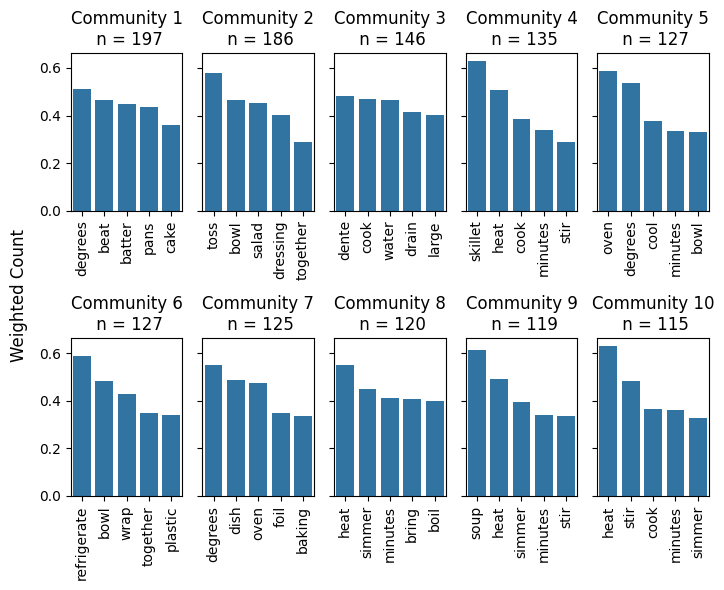

In [149]:
n=10
k=5
def title_dist_for_nodes(nodes, axes, column, weights):
    dats = datacleaning.data_for_nodes(nodes)
    # dats['title_words'] = dats['title'].replace(r'[^a-zA-Z\s]', '', regex=True)
    # dats['title_words'] = dats['title_words'].str.lower()
    # dats['title_words'] = dats['title_words'].str.split()
    dats['title_words'] = dats[column]
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if len(word) > 3])
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if word not in stop_words])
    
    title_words = list(itertools.chain.from_iterable(dats["title_words"]))
    title_freqs = pd.DataFrame(list(FreqDist(title_words).items()), columns = ["word","frequency"])
    
    title_freqs = title_freqs.merge(weights, on = 'word')

    title_freqs['weighted_frequency'] = title_freqs['frequency'] * title_freqs['weight']
    title_freqs = title_freqs.sort_values(by = 'weighted_frequency', ascending = False).head(5)

    sns.barplot(x=title_freqs['word'], y=title_freqs['weighted_frequency']/np.linalg.norm(title_freqs['weighted_frequency']), ax= axes, errorbar=('ci', 0))
    return title_words

def plot_communities(communities, column, weights, title):
    fig, ax = plt.subplots(2,int(n/2), figsize= (7,6), sharey=True)
    i = 1
    plt_i = 0
    plt_j = 0
    for community in communities:
        if len(community) < 100:
            i = i + 1
            continue
        if plt_i + int(n/2)*plt_j >= n:
            break
        if plt_i == int(n/2):
            plt_j = 1
            plt_i = 0
        title_dist_for_nodes(communities[i], ax[plt_j, plt_i], column, weights)
        ax[plt_j, plt_i].tick_params('x', labelrotation=90)
        ax[plt_j, plt_i].set_title("Community " + str(i) + "\n n = " + str(len(community)))
        ax[plt_j, plt_i].set_ylabel("")
        ax[plt_j, plt_i].set_xlabel("")

        plt_i = plt_i + 1
        i = i + 1
    fig.text(-.02, 0.5, 'Weighted Count', va='center', rotation='vertical', size='large')
    # fig.suptitle(title)
    fig.align_xlabels()
    fig.tight_layout()

plot_communities(inst_communities,'instruction_words', instructions_idf,title = "Instruction Words by Instruction Community")

plt.savefig('figs/tfidf_instcommunity_instructions.pdf')

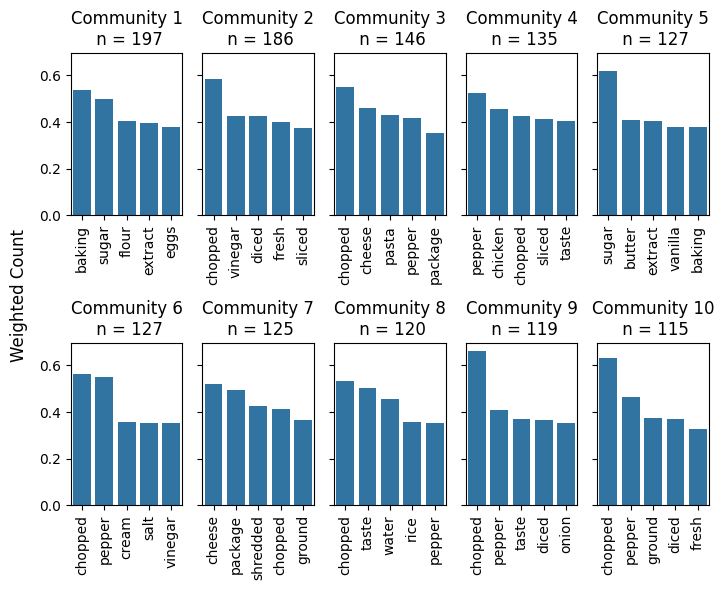

In [150]:
plot_communities(inst_communities,'ingredient_words', ingredients_idf,title = "Ingredient Words by Instruction Community")
plt.savefig('figs/tfidf_instcommunity_ingredients.pdf')

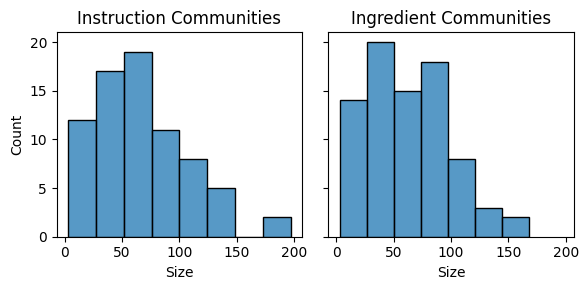

In [146]:
def count_communities(communities):
    coms = sorted(communities, key=len, reverse=True)
    lens = [len(g) for g in coms]
    # s, count = np.unique(np.sort(lens), return_counts=True)
    return lens

def plot_components(data, axes):
    a = sns.histplot(x = data, ax=axes, binwidth=25)

fig, axes = plt.subplots(1,2, figsize= (6,3), sharex=True, sharey=True)
plot_components(count_communities(inst_communities), axes=axes[0])
plot_components(count_communities(ingr_communities), axes=axes[1])
axes[0].set_title("Instruction Communities")
axes[1].set_title("Ingredient Communities")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Size")
axes[1].set_xlabel("Size")
# fig.suptitle("Size of Communities in TFIDF Graphs")

fig.tight_layout()
plt.savefig('figs/tfidf_community_sizes.pdf')

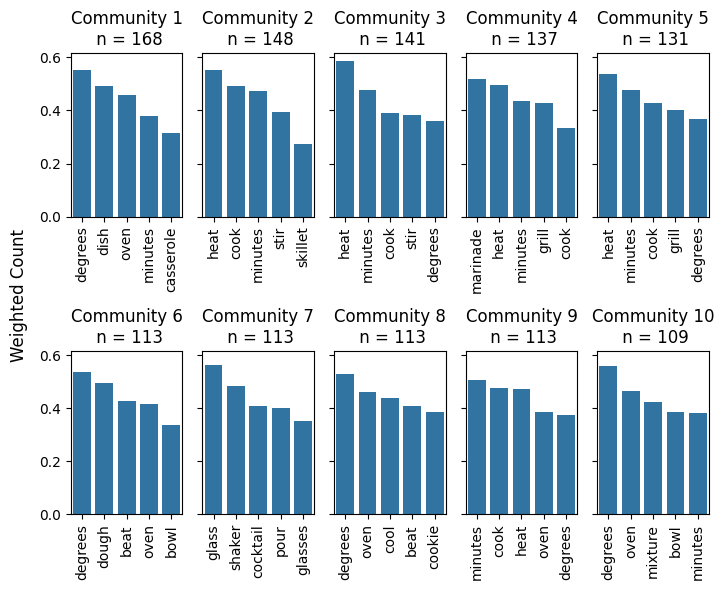

In [154]:
plot_communities(ingr_communities,'instruction_words', instructions_idf,title = "Ingredient Words by Instruction Community")
plt.savefig('figs/tfidf_ingrcommunity_instructions.pdf')

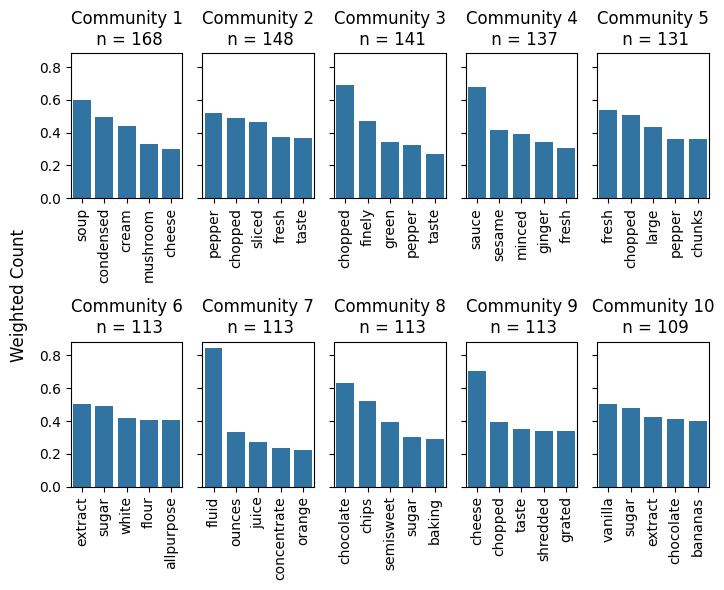

In [152]:
plot_communities(ingr_communities,'ingredient_words', ingredients_idf,title = "Ingredient Words by Instruction Community")
plt.savefig('figs/tfidf_ingrcommunity_ingredients.pdf')

In [148]:
len(ingr_communities) - len(inst_communities)

6

In [30]:
instruction_ranked_tfidf_cent.set_index('Id')

,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,title,...,clean_ingredients,clean_instructions,clean_instructions_masked,ingredient_words,instruction_words,index,degree_centrality,pagerank_centrality,betweenness_centrality,sum_idf
Id,,,,,,,,,,,,,,,,,,,,,
5eA5nRW8VgbOry0hsA.SVnrGkt2AdzO,0,0,0,0,0,0,0,0,0,Southern-Style Chocolate Pound Cake,...,butter shortening white sugar eggs vanilla ext...,preheat oven degrees degrees grease flour loaf...,preheat oven degrees degrees grease loaf pans ...,"[butter, shortening, white, sugar, eggs, vanil...","[preheat, oven, degrees, degrees, grease, loaf...",5eA5nRW8VgbOry0hsA.SVnrGkt2AdzO,0.002601,0.000645,0.004911,150.919070
DIzfv.NycIqtwo58y7fteog1dKRw12O,1,1,1,1,1,1,1,1,1,Pumpkin Pie I,...,egg allpurpose flour white sugar salt pumpkin ...,preheat oven degrees degrees add sugar gradual...,preheat oven degrees degrees add gradually bea...,"[egg, allpurpose, flour, white, sugar, salt, p...","[preheat, oven, degrees, degrees, add, gradual...",DIzfv.NycIqtwo58y7fteog1dKRw12O,0.000600,0.000174,0.001502,119.695606
TFxp0RPK/1PxAnjYiZUS0KztkgYb3iW,2,2,2,2,2,2,2,2,2,Cinnamon Oatmeal Zucchini Cookies,...,butter softened white sugar eggs vanilla extra...,preheat oven degrees degrees grease baking she...,preheat oven degrees degrees grease sheets bea...,"[butter, softened, white, sugar, eggs, vanilla...","[preheat, oven, degrees, degrees, grease, shee...",TFxp0RPK/1PxAnjYiZUS0KztkgYb3iW,0.000400,0.000117,0.000140,155.065822
3yH5Jc6HLmEnJw5ggLqI11oeBiSpwBy,3,3,3,3,3,3,3,3,3,Plum-Oat Drop Biscuits,...,white sugar ground cinnamon allpurpose flour r...,preheat oven degrees degrees grease baking she...,preheat oven degrees degrees grease sheet comb...,"[white, sugar, ground, cinnamon, allpurpose, f...","[preheat, oven, degrees, degrees, grease, shee...",3yH5Jc6HLmEnJw5ggLqI11oeBiSpwBy,0.000400,0.000131,0.000000,179.323968
8lZak.EVdLP9/dukyN72DYHyjseFwV2,4,4,4,4,4,4,4,4,4,Ghirardelli Milk Chocolate Chip Cookies,...,allpurpose flour baking soda salt unsalted but...,preheat oven degrees stir together flour bakin...,preheat oven degrees stir together set aside b...,"[allpurpose, flour, baking, soda, salt, unsalt...","[preheat, oven, degrees, stir, together, set, ...",8lZak.EVdLP9/dukyN72DYHyjseFwV2,0.000600,0.000181,0.002438,201.304162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z5ZKH66nGOR2cgkzDl5vGj4DPX/J95O,4995,4995,4995,4995,4995,4995,4995,4995,4995,Sun-Dried Tomato With Fresh Basil Spread,...,oilpacked sundried tomatoes basil leaves ounce...,place sundried tomatoes work bowl food process...,place work bowl food processor pulse coarsely ...,"[oilpacked, sundried, tomatoes, basil, leaves,...","[place, work, bowl, food, processor, pulse, co...",z5ZKH66nGOR2cgkzDl5vGj4DPX/J95O,0.000600,0.000182,0.001918,89.021971
g1mQzPtIoBSaOaaHSkMj7cObWt0r5.K,4996,4996,4996,4996,4996,4996,4996,4996,4996,Banana Split Martini,...,ice needed fluid ounces white chocolate liqueu...,fill cocktail shaker ice add white chocolate l...,fill cocktail shaker add creme de cover shake ...,"[ice, needed, fluid, ounces, white, chocolate,...","[fill, cocktail, shaker, add, creme, de, cover...",g1mQzPtIoBSaOaaHSkMj7cObWt0r5.K,0.000400,0.000127,0.000000,78.463829
dsDOddsQtDp7xomWY2mQwcoTyLeUfYa,4997,4997,4997,4997,4997,4997,4997,4997,4997,Citrus Glazed Banana Squash,...,banana squash peeled cubed butter water needed...,melt butter large skillet medium heat add squa...,melt large skillet medium heat add cubes cover...,"[banana, squash, peeled, cubed, butter, water,...","[melt, large, skillet, medium, heat, add, cube...",dsDOddsQtDp7xomWY2mQwcoTyLeUfYa,0.000400,0.000130,0.000000,81.057415


In [31]:
i = 1
inst_communities_df = {}
inst_communities_size = {}
com_betweenness = {}
for com in inst_communities:
    inst_communities_df[i] = com
    inst_communities_size[i] = len(com)
    com_data = pd.DataFrame([rec for rec in com]).rename(columns={0: "Id"}).set_index('Id').join(instruction_ranked_tfidf_cent.set_index('Id'))['betweenness_centrality']
    com_betweenness[i] = (sum(com_data)/len(com), max(com_data))
    i = i+1

inst_communities_df = pd.DataFrame(inst_communities_df.items(),columns=['community_num','nodes']).set_index('community_num')


inst_communities_size = pd.DataFrame(inst_communities_size.items(),columns=['community_num','size']).set_index('community_num')

inst_communities_df = inst_communities_df.join(inst_communities_size)
com_betweenness = pd.DataFrame(com_betweenness.items(), columns=['community_num', 'avg_betweenness']).set_index('community_num').sort_values(by='avg_betweenness', ascending = False)
com_betweenness = pd.DataFrame(com_betweenness['avg_betweenness'].tolist(), index=com_betweenness.index).rename(columns = {0:'average',1:'max'})
inst_communities_df = inst_communities_df.join(com_betweenness)

<Axes: xlabel='size', ylabel='average'>

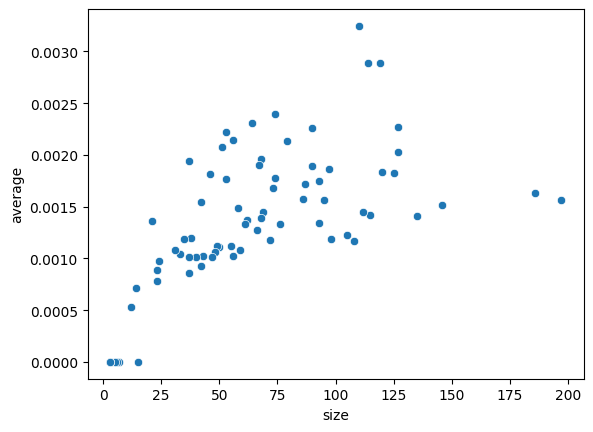

In [32]:
inst_communities_df.sort_values(by='max', ascending=False)

sns.scatterplot(data=inst_communities_df, x='size', y='average')

In [33]:
inst_communities_df.sort_values(by='average', ascending=False)

,nodes,size,average,max
community_num,,,,
13,"{/2w9/8vdPxW6t0OzNjaJBKrAE3C261G, V0iMKokpAj9q...",110,3.246348e-03,4.351792e-02
9,"{ERQwUERD94KEXTtoIs3.cnHbdjtxYE., m2jmearINfcX...",119,2.892531e-03,3.725008e-02
11,"{oNTZ5N8TFVEqPF8i6qvIhJ7pu/9dpKe, BT2MQo3fm8m3...",114,2.890843e-03,7.066136e-02
28,"{CDUE.iiPofTbvZAc5Ei6CnaiovfmAga, 3ZO68LhUpE3E...",74,2.392200e-03,1.540471e-02
36,"{vacyFpXG/Nau/08R6tJn1CPB9EYVovC, dVAe2I3ym6w3...",64,2.308195e-03,1.331422e-02
...,...,...,...,...
70,"{nM7HoDhTjW6wpl3KdSyAGKA6NY1anSa, a8zNv6rs5d2V...",7,1.257897e-07,4.802881e-07
71,"{ACH1m7K9FjVvcfvOYC.DUeA2V2ObgRq, S51lr0m1OHMm...",6,9.338936e-08,2.134614e-07
72,"{8ReximPd.Z1FS2z8xlGAqF18a8n6cay, 9ciKIRfpfHji...",5,4.802881e-08,1.600960e-07


         word  frequency  weighted_frequency
1     cookies        122                 122
31  chocolate         41                  41
32       chip         28                  28
13    oatmeal         17                  17
49     butter         12                  12
..        ...        ...                 ...
3    flavored          1                   1
5   sugarless          1                   1
6      health          1                   1
10     rolled          1                   1
12       lacy          1                   1

[281 rows x 3 columns]
             word  frequency  weighted_frequency
8           salad         24                  24
96          sauce         11                  11
26       dressing          8                   8
22          salsa          8                   8
108         spicy          7                   7
..            ...        ...                 ...
106       whipped          1                   1
107         bills          1                

['roasted',
 'beets',
 'apples',
 'fennel',
 'pecan',
 'french',
 'toast',
 'make',
 'turkey',
 'melt',
 'mouth',
 'turkey',
 'brine',
 'mediterranean',
 'lemon',
 'chicken',
 'pineapple',
 'beef',
 'potato',
 'roast',
 'spatchcock',
 'turkey',
 'eggnog',
 'custard',
 'pesto',
 'chips',
 'best',
 'ugly',
 'turkey',
 'pizza',
 'rustica',
 'peachaberry',
 'pineapple',
 'scones',
 'quebecois',
 'maple',
 'cream',
 'deep',
 'dish',
 'alfredo',
 'pizza',
 'easy',
 'herb',
 'roasted',
 'turkey',
 'roasted',
 'turkey',
 'breast',
 'herbs',
 'saras',
 'beef',
 'jerky',
 'roasted',
 'cabbage',
 'nice',
 'slowcooked',
 'pork',
 'tipsy',
 'chicken',
 'jans',
 'beerbrined',
 'corned',
 'beef',
 'citrus',
 'honey',
 'brined',
 'smoked',
 'turkey',
 'chicken',
 'sandwiches',
 'deepfried',
 'turkey',
 'sticky',
 'chicken',
 'herby',
 'roasted',
 'potato',
 'wedges',
 'slow',
 'cooker',
 'lancaster',
 'county',
 'pork',
 'sauerkraut',
 'harveys',
 'moroccan',
 'roast',
 'chicken',
 'roasted',
 'duck',

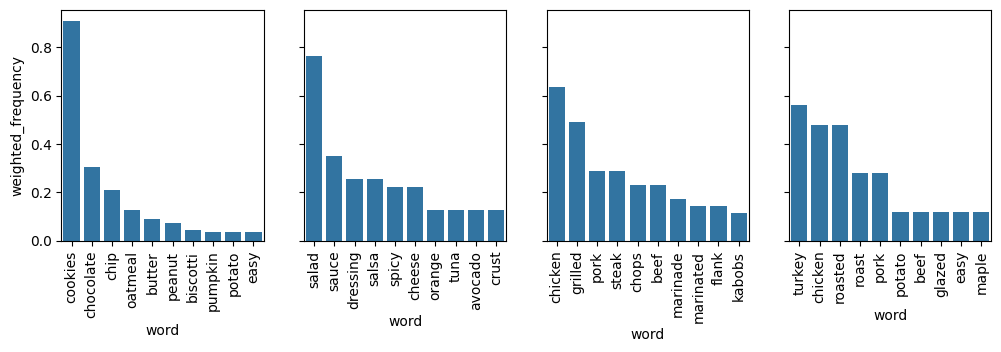

In [34]:

fig, ax = plt.subplots(1,4, figsize= (12,3), sharey=True)

def title_dist_for_nodes(nodes, axes):
    dats = datacleaning.data_for_nodes(nodes)
    dats['title_words'] = dats['title'].replace(r'[^a-zA-Z\s]', '', regex=True)
    dats['title_words'] = dats['title_words'].str.lower()
    dats['title_words'] = dats['title_words'].str.split()
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if len(word) > 3])
    dats['title_words'] = dats['title_words'].apply(lambda x: [word for word in x if word not in stop_words])
    
    title_words = list(itertools.chain.from_iterable(dats["title_words"]))
    title_freqs = pd.DataFrame(list(FreqDist(title_words).items()), columns = ["word","frequency"])

    title_freqs['weighted_frequency'] = title_freqs['frequency']
    
    title_freqs = title_freqs.sort_values(by = 'weighted_frequency', ascending= False)
    print(title_freqs)
    title_freqs = title_freqs.head(10)
    sns.barplot(x=title_freqs['word'], y=title_freqs['weighted_frequency']/np.linalg.norm(title_freqs['weighted_frequency']), ax= axes, errorbar=('ci', 0))
    axes.tick_params('x', labelrotation=90)
    return title_words


title_dist_for_nodes(inst_communities_df.loc[1]['nodes'], ax[0])
title_dist_for_nodes(inst_communities_df.loc[7]['nodes'], ax[1])
title_dist_for_nodes(inst_communities_df.loc[18]['nodes'], ax[2])
title_dist_for_nodes(inst_communities_df.loc[33]['nodes'], ax[3])

# inst_communities_df.loc[list(com_betweenness.index)[1]]['nodes']

In [46]:
datacleaning.data_for_nodes(inst_communities_df.loc[33]['nodes'])

,title,ingredients,instructions,picture_link,clean_ingredients,clean_instructions,clean_instructions_masked,title_words,ingredient_words,instruction_words,index
Id,,,,,,,,,,,
vjYOEhk8Ocw6RJiAIEMK4jeRY4714Z2,"Roasted Beets, Apples, and Fennel","5 medium beets, peeled and quartered ADVERTISE...",Preheat oven to 400 degrees F (200 degrees C)....,/VVx9nrDWAZCQQ/juxRri/UwM9i.ase,medium beets peeled quartered apples cored cho...,preheat oven degrees degrees place beets apple...,preheat oven degrees degrees place large roast...,"[roasted, beets, apples, and, fennel]","[medium, beets, peeled, quartered, apples, cor...","[preheat, oven, degrees, degrees, place, large...",vjYOEhk8Ocw6RJiAIEMK4jeRY4714Z2
3yffub9YKNOdXrH./9Pb0PaVac5b9bC,Pecan French Toast,4 eggs ADVERTISEMENT 2/3 cup orange juice ADVE...,"In a large bowl, beat together eggs, orange ju...",1ILbnUnzhzjXAGPTqJtr3V9y6YqfjyK,eggs orange juice milk white sugar nutmeg vani...,large bowl beat together eggs orange juice mil...,large bowl beat together place tightly spaced ...,"[pecan, french, toast]","[eggs, orange, juice, milk, white, sugar, nutm...","[large, bowl, beat, together, place, tightly, ...",3yffub9YKNOdXrH./9Pb0PaVac5b9bC
4kkg3fouKjNp9O2Aor4buw7gZgg5guy,Make Your Turkey Melt in Your Mouth Turkey Brine,9 (14.5 ounce) cans chicken broth ADVERTISEMEN...,Combine chicken broth and apple juice in a foo...,FlcZTs6L52yz7cHo9UFHLPztLwipj6i,cans chicken broth fluid bottle apple juice or...,combine chicken broth apple juice foodsafe con...,combine foodsafe container enough hold turkey ...,"[make, your, turkey, melt, in, your, mouth, tu...","[cans, chicken, broth, fluid, bottle, apple, j...","[combine, foodsafe, container, enough, hold, t...",4kkg3fouKjNp9O2Aor4buw7gZgg5guy
13110QKMj0hc4ECTQZJTn7weRXgnHaq,Mediterranean Lemon Chicken,1 lemon ADVERTISEMENT 2 teaspoons dried oregan...,Preheat oven to 425 degrees F (220 degrees C)....,eGj3KLzvYOFBXtNDQNn0/oK9y3/gP.6,lemon dried oregano cloves garlic minced olive...,preheat oven degrees degrees x baking dish gra...,preheat oven degrees degrees x baking dish gra...,"[mediterranean, lemon, chicken]","[lemon, dried, oregano, cloves, garlic, minced...","[preheat, oven, degrees, degrees, x, baking, d...",13110QKMj0hc4ECTQZJTn7weRXgnHaq
83vgnSsiI8O2waHOmMxyXtvgjb33GBy,Ham with Pineapple,1 (12 pound) bone-in ham ADVERTISEMENT 1/2 cup...,Preheat the oven to 325 degrees F (160 degrees...,5LX88Ns5F5l2.QgNEjaCz86tE7To/1O,bonein ham whole cloves pineapple rings heavy ...,preheat oven degrees degrees place ham roastin...,preheat oven degrees degrees place roasting pa...,"[ham, with, pineapple]","[bonein, ham, whole, cloves, pineapple, rings,...","[preheat, oven, degrees, degrees, place, roast...",83vgnSsiI8O2waHOmMxyXtvgjb33GBy
...,...,...,...,...,...,...,...,...,...,...,...
H65OtOXu5WMe6Tuo0IoyhP6xZrYCY3i,Perfect Baked Potato,1 medium baking potato ADVERTISEMENT 1 teaspoo...,Preheat the oven to 300 degrees F (150 degrees...,EvABvTXsztVnv3JlucWpGM9C9lHvGx6,medium baking potato olive oil salt butter pin...,preheat oven degrees degrees scrub potato pier...,preheat oven degrees degrees scrub pierce skin...,"[perfect, baked, potato]","[medium, baking, potato, olive, oil, salt, but...","[preheat, oven, degrees, degrees, scrub, pierc...",H65OtOXu5WMe6Tuo0IoyhP6xZrYCY3i
0O.28mD9i56zdsf.MBuXIvGAMgO3.Jq,Olive Oil Roasted Eggplant with Lemon,1 large eggplant ADVERTISEMENT 3 tablespoons e...,Preheat the oven to 400 degrees F (200 degrees...,BMHk21z/W6GUUZk0l2XHBfAq6Kh6C1e,large eggplant extra virgin olive oil salt pep...,preheat oven degrees degrees line baking sheet...,preheat oven degrees degrees line baking sheet...,"[olive, oil, roasted, eggplant, with, lemon]","[large, eggplant, extra, virgin, olive, oil, s...","[preheat, oven, degrees, degrees, line, baking...",0O.28mD9i56zdsf.MBuXIvGAMgO3.Jq
PXd5aqQ3xLqu6f9dW/ouP4VL.p.b0BK,Gigot D'Agneau au Four (Roast Lamb with Beans),1 (3 pound) leg of lamb ADVERTISEMENT 6 cloves...,Preheat oven to 425 degrees F (220

In [47]:
i = 1
thing = {}
for com in inst_communities:
    thing.update({movie:i for movie in com})
    i = i+1

nx.set_node_attributes(graph_recipe_instruction_ranked_tfidf, thing, "class")


In [48]:
nx.write_gexf(graph_recipe_instruction_ranked_tfidf, "recipe_instruction_ranked_tfidf.gexf")

In [49]:
G_mm = graph_recipe_instruction_ranked_tfidf

merged_G_mm = nx.Graph()
added_nodes = {}
for node, data in G_mm.nodes(data = True):
    if data["class"] not in added_nodes:
        new_node = data["class"]
        added_nodes[data["class"]] = new_node
        merged_G_mm.add_node(new_node, internal_edges = 0)
    else:   
        new_node = added_nodes[data["class"]]
    neighbors = nx.all_neighbors(G_mm, node)
    for neighbor in neighbors:
        if (G_mm.nodes[neighbor]["class"]) == new_node:
            updated_internal_edges = merged_G_mm.nodes[data["class"]].get("internal_edges") + (G_mm.get_edge_data(node, neighbor)).get("weight")
            nx.set_node_attributes(merged_G_mm, {data["class"]: updated_internal_edges},"internal_edges" )

        elif merged_G_mm.get_edge_data(G_mm.nodes[neighbor]["class"], new_node) == None:
            merged_G_mm.add_edge(G_mm.nodes[neighbor]["class"], new_node)
            nx.set_edge_attributes(merged_G_mm, {(G_mm.nodes[neighbor]["class"],new_node):{"weight": (G_mm.get_edge_data(node, neighbor)).get("weight")}})

        elif merged_G_mm.get_edge_data(G_mm.nodes[neighbor]["class"], new_node) != None:
            updated_edge_weight = merged_G_mm.get_edge_data(G_mm.nodes[neighbor]["class"], new_node).get("weight") + (G_mm.get_edge_data(node, neighbor)).get("weight")
            nx.set_edge_attributes(merged_G_mm, {(G_mm.nodes[neighbor]["class"], new_node) : {"weight" : updated_edge_weight}})


In [50]:
nx.write_gexf(merged_G_mm, "com_recipe_instruction_ranked_tfidf.gexf")

'DIzfv.NycIqtwo58y7fteog1dKRw12O'

In [133]:
# An absurdly dumb way to calculate adjacency matrix difference for particular nodes
def dict_distance(dict1, dict2):
  output = 0
  for key in set(dict1.keys()) | set(dict2.keys()):
    if key in dict1 and key in dict2:
      output += abs(dict1[key] - dict2[key])
    elif key in dict1:
      output += abs(dict1[key])
    else:
      output += abs(dict2[key])
  return output

def node_distance(node, graph1, graph2):
    n1 = {n:graph1[node][n]["weight"] for n in graph1[node]}
    n2 = {n:graph2[node][n]["weight"] for n in graph2[node]}
    return dict_distance(n1, n2)

# node_distance(list(graph_recipe_instruction_ranked_tfidf.nodes)[1], graph_recipe_ingredient_ranked_tfidf, graph_recipe_instruction_ranked_tfidf)
from random import sample

def total_distance(G1, G2):
  node_distances = {}
  for node in list(G1.nodes):
      node_distances[node] = (node_distance(node, G1, G2))
  node_distances = pd.DataFrame(node_distances.items(), columns=['Id','distance'])
  # print(node_distances)
  return sum(node_distances['distance'])/5000

In [131]:
print(total_distance(graph_instruction, graph_recipe_ingredient_ranked_tfidf))

93.16124433109653


In [132]:
print(total_distance(graph_instruction, graph_recipe_instruction_ranked_tfidf))

91.28943230813981


In [117]:
node_distances.set_index('Id').join(data.set_index('Id')).sort_values(by='distance', ascending = False)

,distance,title,ingredients,instructions,picture_link,clean_ingredients,clean_instructions,clean_instructions_masked,title_words,ingredient_words,instruction_words,index
Id,,,,,,,,,,,,
.HZRwc6stnvkdXfxHMogOEkrldKfV8q,10.835016,Best Ever Chocolate Chip Cookies II,"1 cup butter, melted ADVERTISEMENT 2 cups brow...",Preheat the oven to 375 degrees F (190 degrees...,0gHlb5KQIEFV.wz798bfMt6i7roi2gi,butter melted brown sugar eggs allpurpose flou...,preheat oven degrees degrees line cookie sheet...,preheat oven degrees degrees line cookie sheet...,"['best', 'ever', 'chocolate', 'chip', 'cookies...","[butter, melted, brown, sugar, eggs, allpurpos...","[preheat, oven, degrees, degrees, line, cookie...",.HZRwc6stnvkdXfxHMogOEkrldKfV8q
6E22ebx3Sm037B.Zc3AbNWAqiqDve5m,10.178107,Vegetable Soup II,"2 stalks celery, chopped ADVERTISEMENT 1 onion...","In a large pot over medium heat, saute the cel...",ooJThxB3r7hQMnJ8xGVicDn.3Reb5pG,stalks celery chopped onion chopped olive oil ...,large pot medium heat saute celery onion oil m...,large pot medium heat saute minutes onions ten...,"['vegetable', 'soup', 'ii']","[stalks, celery, chopped, onion, chopped, oliv...","[large, pot, medium, heat, saute, minutes, oni...",6E22ebx3Sm037B.Zc3AbNWAqiqDve5m
uIrbBOnJThEbSQMlz8liYRMgt4dvoY.,10.040038,Grandma VanDoren's White Bread,3 cups warm water ADVERTISEMENT 3 tablespoons ...,"In a large bowl, combine warm water, yeast, sa...",u1QXERQx3xeoNt.9bHWZuW3/QTXlu8a,warm water active dry yeast salt vegetable oil...,large bowl combine warm water yeast salt oil s...,large bowl combine mix thoroughly let sponge r...,"['grandma', 'vandorens', 'white', 'bread']","[warm, water, active, dry, yeast, salt, vegeta...","[large, bowl, combine, mix, thoroughly, let, s...",uIrbBOnJThEbSQMlz8liYRMgt4dvoY.
NKq9wiGBlEt0ws9FAFb6518awFKIqRe,9.418697,Butter-Roasted Cauliflower,"1 head cauliflower, cut into large florets ADV...",Preheat oven to 400 degrees F (200 degrees C)....,cqSVFuuQ8BRXQJcAt63K/vg9pxbZ7R6,head cauliflower cut large florets butter melt...,preheat oven degrees degrees line baking sheet...,preheat oven degrees degrees line baking sheet...,"['butterroasted', 'cauliflower']","[head, cauliflower, cut, large, florets, butte...","[preheat, oven, degrees, degrees, line, baking...",NKq9wiGBlEt0ws9FAFb6518awFKIqRe
BqfGsVgk7WHPebuzDH3IIRDAo0Vy8Hy,7.437390,Refreshing Mango Chutney,"1 red onion, chopped ADVERTISEMENT 1 mango - p...","Mix red onion, mango, tomato, and cilantro tog...",qE58a7Z1Au0GXvPO188iHZZVqna9hLa,red onion chopped mango peeled seeded chopped ...,mix red onion mango tomato cilantro together bowl,mix together bowl,"['refreshing', 'mango', 'chutney']","[red, onion, chopped, mango, peeled, seeded, c...","[mix, together, bowl]",BqfGsVgk7WHPebuzDH3IIRDAo0Vy8Hy
...,...,...,...,...,...,...,...,...,...,...,...,...
Py2l9VylbiP1fVcviFStJ2iuITj7KeK,1.416930,Chinese Roasted Chicken,1 (4 pound) fresh or thawed whole roasting chi...,Remove and discard giblets and neck from chick...,5HVwQXPfdQiB95MW5LsJ8b9659yG5R6,fresh thawed whole roasting chicken kikkoman l...,remove discard giblets neck chicken rinse chic...,remove discard giblets neck rinse cold running...,"['chinese', 'roasted', 'chicken']","[fresh, thawed, whole, roasting, chicken, kikk...","[remove, discard, giblets, neck, rinse, cold, ...",Py2l9VylbiP1fVcviFStJ2iuITj7KeK
u7AXfU5kcKZuZXPkFIeSG.4SSOF.4o.,1.120697,Bistecca alla Fiorentina (Tuscan Porterhouse),"4 sprigs fresh rosemary, chopped ADVERTISEMENT...",Press chopped rosemary onto both sides of port...,GXOnIrwvZUoO6Q5MtEVy8VqQ34XBQpG,sprigs fresh rosemary chopped choice prime por...,press chopped rosemary onto sides porterhouse ...,press onto sides set onto plate allow marinate...,"['bistecca', 'alla', 'fiorentina', 'tuscan', '...","[sprigs, fresh, rosemary, chopped, choice, pri...","[press, onto, sides, set, onto, plate, allow, ...",u7AXfU5kcKZuZXPkFIeSG.4SSOF.4o.
1LqHZdGYqVUX9kx4N9HgFdpj.Z0SOVa,1.034508,Mashed Potato Stuffed Cannoli,For the Parmesan cannoli: 